Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor as GDBT
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

Привязываем гугл-диск для загрузкии датасетов. Берем один из них для первочного анализа.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
df_microsoft = pd.read_csv('/content/drive/MyDrive/datasets/microsoft.csv')
df_microsoft.head(5)

,Date,Open,High,Low,Close,Volume,Currency
0,2010-01-04,30.62,31.10,30.59,30.95,38414184,USD
1,2010-01-05,30.85,31.10,30.64,30.96,49758864,USD
2,2010-01-06,30.88,31.08,30.52,30.77,58182332,USD
3,2010-01-07,30.63,30.70,30.19,30.45,50564284,USD
4,2010-01-08,30.28,30.88,30.24,30.66,51201288,USD


Берем второй датасет из геймдеав-компании для сравнения.

In [5]:
df_nintendo = pd.read_csv('/content/drive/MyDrive/datasets/nintendo.csv')
df_nintendo.head(5)

,Date,Open,High,Low,Close,Volume,Currency
0,2010-01-04,30.25,30.95,30.25,30.90,105408,USD
1,2010-01-05,31.15,32.50,31.05,31.47,210553,USD
2,2010-01-06,32.90,33.40,31.81,33.15,367749,USD
3,2010-01-07,33.90,34.35,33.90,34.22,416643,USD
4,2010-01-08,34.55,34.85,34.40,34.82,441858,USD


Аналогично смотрим на другие датасеты, чтобы проверить схожсть их формата. Далее мы анализируем один датасет, его признаки, чтобы привести его в формат, пригодный для машинного обучения.

In [6]:
df_microsoft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3191 entries, 0 to 3190
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      3191 non-null   object 
 1   Open      3191 non-null   float64
 2   High      3191 non-null   float64
 3   Low       3191 non-null   float64
 4   Close     3191 non-null   float64
 5   Volume    3191 non-null   int64  
 6   Currency  3191 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 174.6+ KB


В датасете нет пропусков. Ничего выполнять не нужно.

In [7]:
df_microsoft.Currency.value_counts()

USD    3191
Name: Currency, dtype: int64

Этот признак можно отбромить, потому что в нем тольео одно значение. Отбрасываем сразу ддля всех датафреймов, всех акций. (Конечно, до этого проверяем, что везде есть только доллары и не затесалась какая-то другая валюта.)

In [8]:
df_microsoft.drop(['Currency'], axis=1).head()

,Date,Open,High,Low,Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,38414184
1,2010-01-05,30.85,31.10,30.64,30.96,49758864
2,2010-01-06,30.88,31.08,30.52,30.77,58182332
3,2010-01-07,30.63,30.70,30.19,30.45,50564284
4,2010-01-08,30.28,30.88,30.24,30.66,51201288


Построю матрицу корреляций, чтобы посмотреть, необходимо ли убрать какие-то признаки.

In [9]:
df_microsoft.corr()

<ipython-input-9-d5bc382a3cd7>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_microsoft.corr()


,Open,High,Low,Close,Volume
Open,1.000000,0.999909,0.999885,0.999772,-0.312391
High,0.999909,1.000000,0.999848,0.999878,-0.309798
Low,0.999885,0.999848,1.000000,0.999891,-0.316006
Close,0.999772,0.999878,0.999891,1.000000,-0.313308
Volume,-0.312391,-0.309798,-0.316006,-0.313308,1.000000


Вообще здесь везде оень высокие корреляции почти, но ценой на открытии акии и на закрытии она прям очень высокая. Попробуем "слить" их в одну переменную.

Далее есть гипотеза, что можно объединить в один признак фичи open и close и поместить в датафрейм разницу между ними вместо самих этих признаков. То есть будет 1 новая фича вместо двуз старых. При этом это должен быть новый датафрейм для постановки новых гипотез.

In [10]:
#ваш код здесь
df_beta = pd.DataFrame({
    'Date': df_microsoft['Date'],
    'Open-Close': df_microsoft['Close']-df_microsoft['Open'],
    })
df_beta.head(10)

,Date,Open-Close
0,2010-01-04,0.33
1,2010-01-05,0.11
2,2010-01-06,-0.11
3,2010-01-07,-0.18
4,2010-01-08,0.38
5,2010-01-11,-0.44
6,2010-01-12,-0.08
7,2010-01-13,0.09
8,2010-01-14,0.65
9,2010-01-15,-0.22


Далее мы помотрим каждый признак датасета на выбросы при помощи ящичковой диаграммы

Здесь мы видим, что у нас очень много выбросов. Попробем их хотя бы немного подчистить. Давайте уберем все выбросы, которые выше значения 0.6, задав им, например, среднее по фиче. Сначала найдем среднее.

In [12]:
mean = df_microsoft['Volume'].mean()
mean

38246878.50015669

Далее мы зададим каждому выбросу вот это значение среднего, а потом снова построим ящичковую диаграмму.

<Axes: >

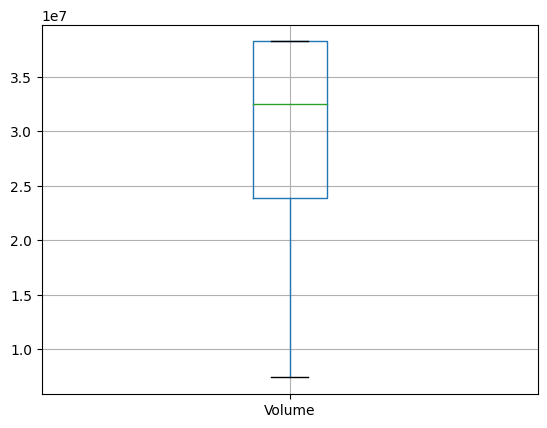

In [13]:
df_beta['Volume'] = [df_microsoft['Volume'][i] if df_microsoft['Volume'][i] <= mean else mean for i in range(df_microsoft.shape[0])]
df_beta.boxplot(column=['Volume'])

In [14]:
def outflies_away(df):
    mean = df.mean()
    df = [df.iloc[i] if df.iloc[i] <= mean else mean for i in range(df.shape[0])]
    return pd.Series(df)

Netflix 1.1959
act_bliz 0.1801
ea 0.2612
microsoft 0.1897
nintendo 0.3637
take_two 0.4977
tencent 0.3044
ubisoft 0.321
zynga 0.1155
MEAN SCORE: 0.3810222222222222


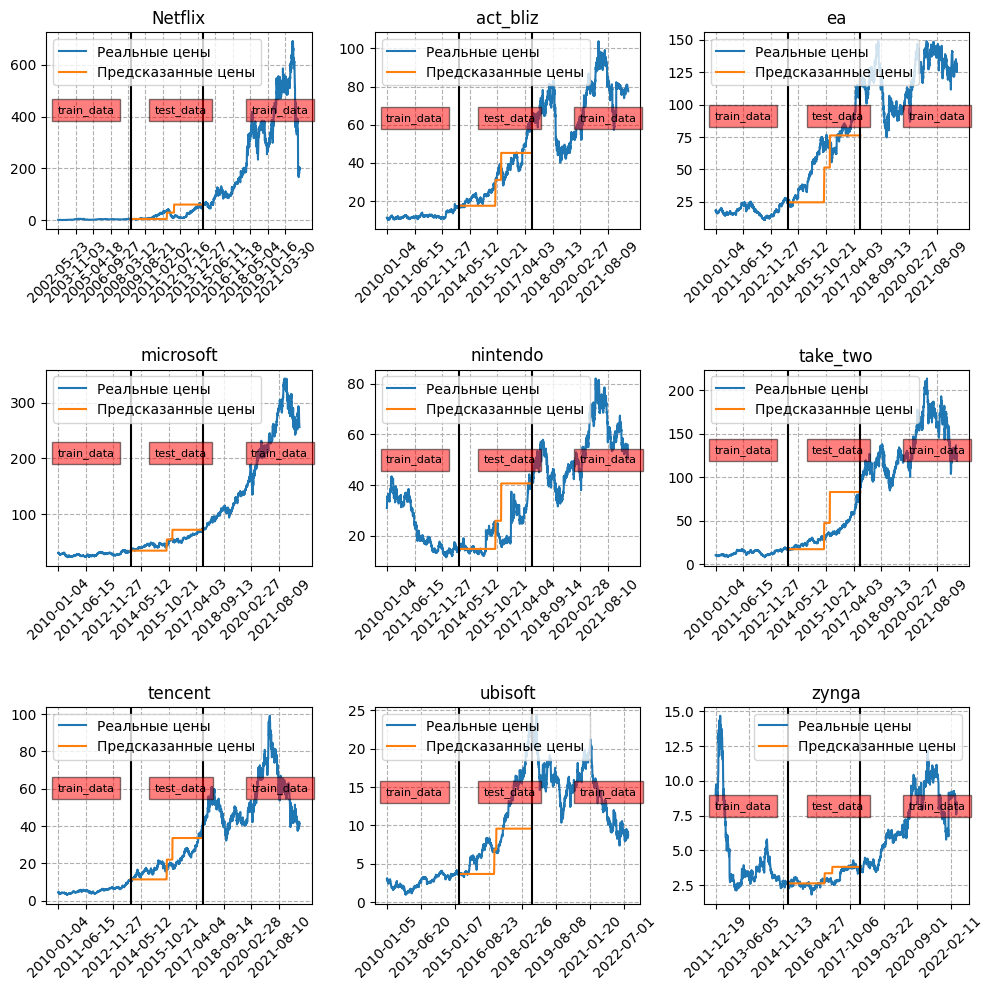

In [38]:
file_path = sorted(glob('drive/MyDrive/datasets/*.csv'))

def normalize(data):
    data['Year'] = [int(data['Date'][i][:4]) for i in range(data.shape[0])]
    data['Month'] = [int(data['Date'][i][5:7]) for i in range(data.shape[0])]
    data['Day'] = [int(data['Date'][i][8:]) for i in range(data.shape[0])]
    data['Date_int'] = data['Year']*365+data['Month']*30+data['Day']
    return data

i = 1
s = []
plt.rcParams['figure.figsize'] = [10,10]
model = RandomForestRegressor(n_estimators = 100)
for f in file_path:
    df = normalize(pd.read_csv(f))

    l = int(df.shape[0]*0.3)
    r = int(df.shape[0]*0.6)

    y = df['Close']
    y_train = y
    X = df[['Year', 'Date_int']]

    X_train = pd.concat([X[:l], X[r:]])
    y_train = pd.concat([y_train[:l], y_train[r:]])
    y_train = outflies_away(y_train)
    X_test = X[l:r]
    y_test = y[l:r]

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    plt.subplot(3,3, i)
    plt.tight_layout(h_pad = 3)
    metrics = round(mean_absolute_percentage_error(y_test, preds), 4)
    print(f[23:-4], metrics)
    s += [metrics]
    plt.plot(df['Date'], y)
    plt.plot(df['Date'][l:r], preds)
    plt.grid(linestyle = '--')
    plt.axvline(x = l, color = 'k', label = 'axvline - full height')
    plt.axvline(x = r, color = 'k', label = 'axvline - full height')
    shape = df.shape[0]
    plt.text(-10, int(y.max()*0.6), 'train_data', fontsize = 8, bbox = dict(facecolor = 'red', alpha = 0.5))
    plt.text(int(shape*0.4), int(y.max()*0.6), 'test_data', fontsize = 8, bbox = dict(facecolor = 'red', alpha = 0.5))
    plt.text(int(shape*0.8), int(y.max()*0.6), 'train_data', fontsize = 8, bbox = dict(facecolor = 'red', alpha = 0.5))
    plt.legend(('Реальные цены','Предсказанные цены'))
    plt.xticks(np.arange(0, df.shape[0], 365), rotation = 45)
    plt.title(f[23:-4])
    i += 1
print('MEAN SCORE:', np.mean(s))
plt.show()

[Text(1, 0, 'Netflix'),
 Text(2, 0, 'act_bliz'),
 Text(3, 0, 'ea'),
 Text(4, 0, 'microsoft'),
 Text(5, 0, 'nintendo'),
 Text(6, 0, 'take_two'),
 Text(7, 0, 'tencent'),
 Text(8, 0, 'ubisoft'),
 Text(9, 0, 'zynga')]

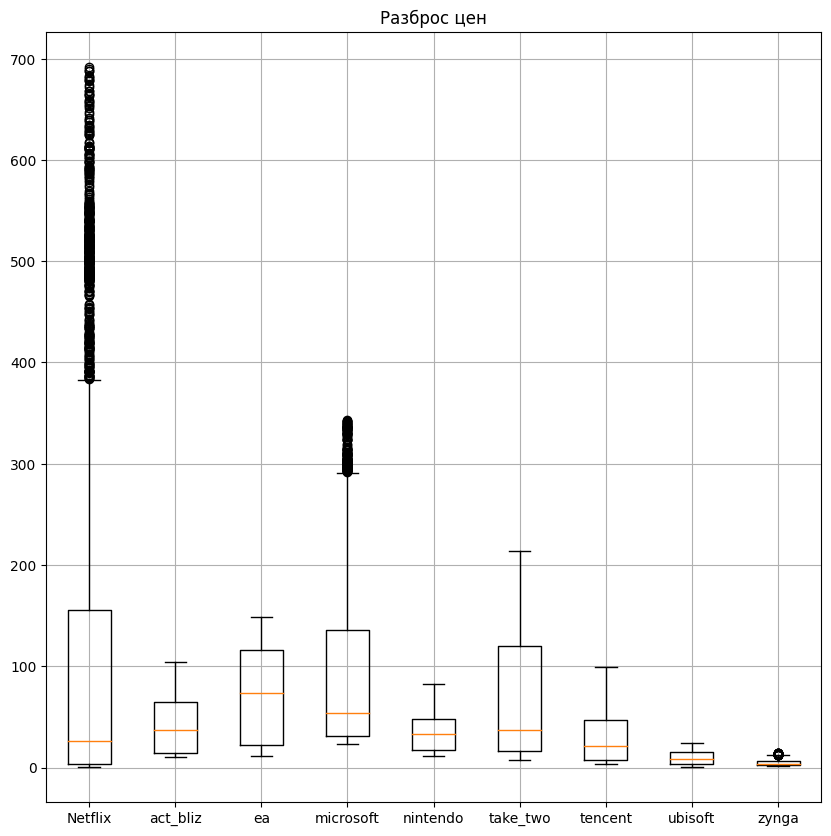

In [46]:
data = {
    file_path[i][23:-4]: pd.read_csv(file_path[i])['Close'] for i in range(len(file_path))
}
fig, ax = plt.subplots()
ax.boxplot(data.values())
plt.title('Разброс цен')
plt.grid(True)
ax.set_xticklabels(data.keys())

[Text(1, 0, 'Netflix'),
 Text(2, 0, 'act_bliz'),
 Text(3, 0, 'ea'),
 Text(4, 0, 'microsoft'),
 Text(5, 0, 'nintendo'),
 Text(6, 0, 'take_two'),
 Text(7, 0, 'tencent'),
 Text(8, 0, 'ubisoft'),
 Text(9, 0, 'zynga')]

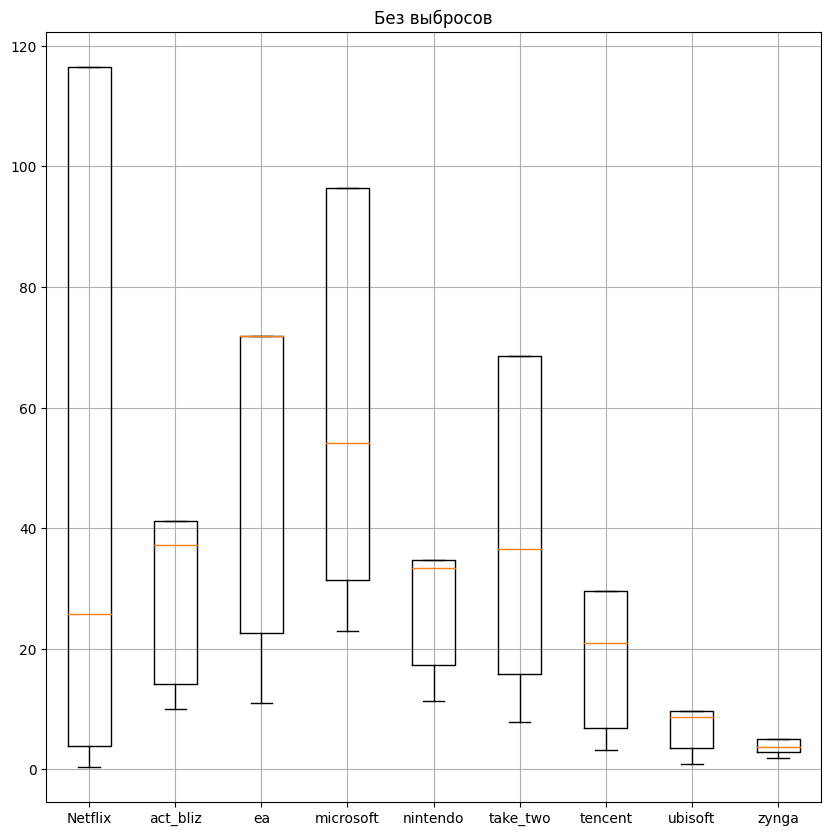

In [47]:
for key in data.keys():
    mean = np.mean(data[key])
    data[key] = [data[key][i] if data[key][i] <= mean else mean for i in range(len(data[key]))]
fig, ax = plt.subplots()
ax.boxplot(data.values())
plt.title('Без выбросов')
plt.grid(True)
ax.set_xticklabels(data.keys())

Рост акций всех компаний

In [ ]:
dates = pd.date_range('2024-01-01', periods = 365)
df = pd.DataFrame(
    {
        'Day': pd.DatetimeIndex(dates).day,
        'Month': pd.DatetimeIndex(dates).month,
        'Year': pd.DatetimeIndex(dates).year,
    })
values = {}
for i in range(len(file_path)):
    df['Date_int'] = df['Day']+df['Month']*30+df['Year']*365
    X = normalize(pd.read_csv(file_path[i]))
    y = X['Close']
    X = X[['Year','Date_int']]
    model.fit(X, y)
    preds = model.predict(df[['Year', 'Date_int']])
    values[file_path[i][23:-4]] = np.mean(preds)

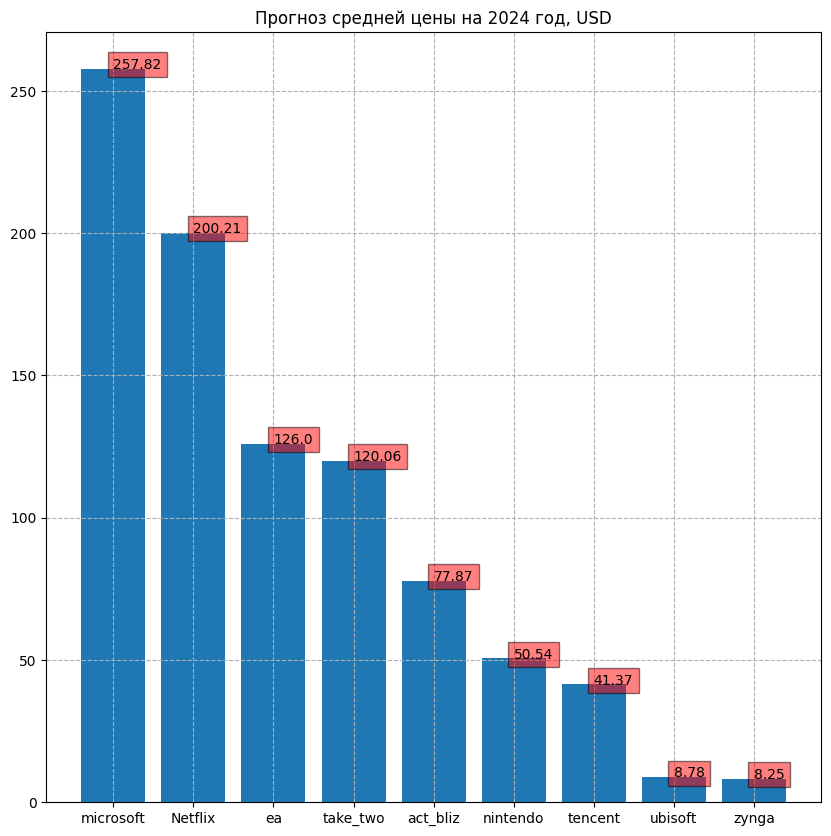

In [ ]:
values_list = sorted(values.items(), key = lambda x: x[1], reverse = True)
values = {values_list[i][0]: values_list[i][1] for i in range(len(values_list))}

plt.bar(values.keys(), values.values())
plt.grid(linestyle = '--')

for i in range(len(values)):
    plt.text(i, values_list[i][1], round(values_list[i][1], 2), bbox = dict(facecolor = 'red', alpha = 0.5))
plt.title('Прогноз средней цены на 2024 год, USD')
plt.show()

ARIMA

<ipython-input-32-22f045fa8144>:5: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('drive/MyDrive/datasets/'+file_name, header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)['Close']
<ipython-input-32-22f045fa8144>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(x, '%Y-%m-%d')
100%|██████████| 365/365 [02:09<00:00,  2.82it/s]


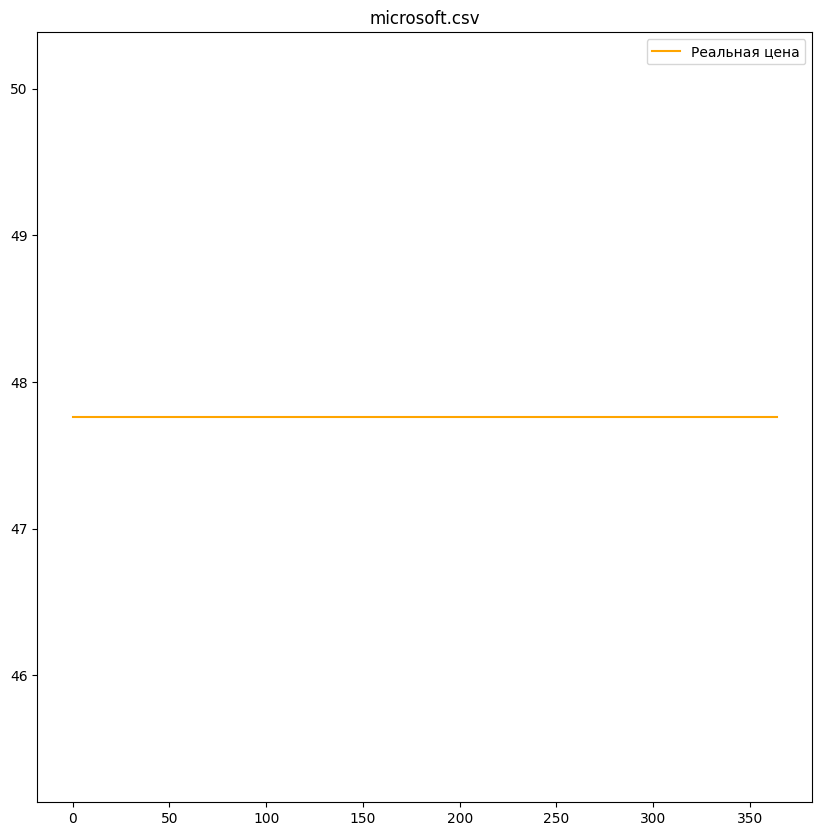

In [32]:
# load dataset
def parser(x):
    return pd.datetime.strptime(x, '%Y-%m-%d')
file_name = 'microsoft.csv'
series = pd.read_csv('drive/MyDrive/datasets/'+file_name, header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)['Close']
series = series[:365*4]
series.index = series.index.to_period('M')

# split into train and test sets
X = series.values
size = int(len(X) * 0.8)
train = X
history = [x for x in train]
predictions = []
# walk-forward validation

for t in tqdm(range(365)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    #print('predicted=%f, expected=%f' % (yhat, obs))

plt.plot(predictions, color='orange')
plt.title(file_name)
plt.legend(['Реальная цена', 'Предсказанная цена'])
plt.show()

<ipython-input-136-dfb963e4f7eb>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

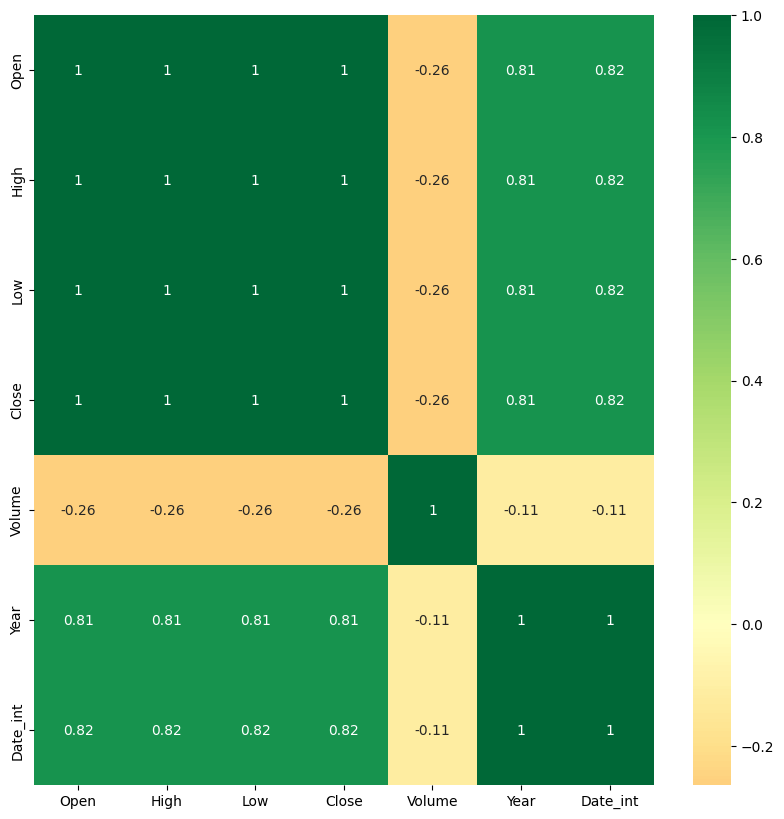

In [ ]:
df = normalize(pd.read_csv(file_path[0])).drop(columns = ['Day', 'Month', 'Adj Close'])
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdYlGn', center=0, annot=True)

<ipython-input-228-ea67741431e5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_summary['Close'] = preds


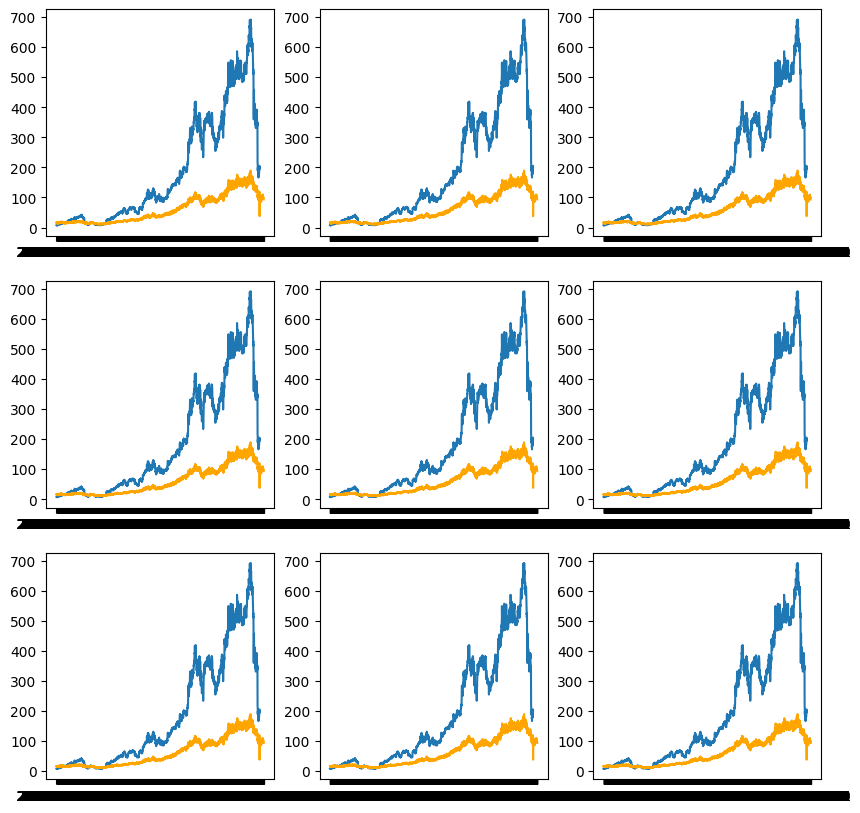